In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp
import statsmodels.api as sm
import os

In [297]:
cleaned_data = pd.read_csv("nse500_prices_cleaned.csv", index_col=0, parse_dates=True, low_memory=False, dayfirst=True)
mapped_market_cap = pd.read_csv("mapped_market_cap.csv", index_col=0, parse_dates=True, low_memory=False, dayfirst=True)
risk_free = pd.read_csv("risk_free_rate.csv", index_col=0, parse_dates=True, dayfirst=True, date_format="%d-%m-%Y")
nifty50 = pd.read_csv("nifty50_data.csv", index_col=0, parse_dates=True, dayfirst=True)
bse200 = pd.read_csv("bse200_data.csv", index_col=0, parse_dates=True, dayfirst=True)
pb_ratios = pd.read_csv("pb_ratio.csv", index_col=0, parse_dates=True)

In [298]:
print(cleaned_data.dtypes)
print(mapped_market_cap.dtypes)
print(risk_free.dtypes)
print(nifty50.dtypes)
#print(bse200.dtypes)
print(pb_ratios.dtypes)

360 One Wam Ltd.                                      object
3M India Ltd.                                        float64
A B B India Ltd.                                     float64
A C C Ltd.                                           float64
A I A Engineering Ltd.                               float64
                                                      ...   
Z F Commercial Vehicle Control Systems India Ltd.    float64
Zee Entertainment Enterprises Ltd.                   float64
Zensar Technologies Ltd.                             float64
Zomato Ltd.                                           object
Zydus Lifesciences Ltd.                              float64
Length: 500, dtype: object
360 One Wam Ltd.                                      object
3M India Ltd.                                        float64
A B B India Ltd.                                     float64
A C C Ltd.                                           float64
A I A Engineering Ltd.                               float

In [299]:
# Convert all values to numeric, forcing non-numeric entries to NaN
cleaned_data = cleaned_data.apply(pd.to_numeric, errors='coerce')
mapped_market_cap = mapped_market_cap.apply(pd.to_numeric, errors='coerce')

In [300]:
print(cleaned_data.dtypes)
print(mapped_market_cap.dtypes)

360 One Wam Ltd.                                     float64
3M India Ltd.                                        float64
A B B India Ltd.                                     float64
A C C Ltd.                                           float64
A I A Engineering Ltd.                               float64
                                                      ...   
Z F Commercial Vehicle Control Systems India Ltd.    float64
Zee Entertainment Enterprises Ltd.                   float64
Zensar Technologies Ltd.                             float64
Zomato Ltd.                                          float64
Zydus Lifesciences Ltd.                              float64
Length: 500, dtype: object
360 One Wam Ltd.                                     float64
3M India Ltd.                                        float64
A B B India Ltd.                                     float64
A C C Ltd.                                           float64
A I A Engineering Ltd.                               float

In [301]:
# 1. Find number of missing values in each column
# Recheck missing values
missing_cleaned = cleaned_data.isna().sum()
missing_mapped = mapped_market_cap.isna().sum()

# Print missing values per column
print("Missing values in nse500_prices_cleaned.csv:")
print(missing_cleaned[missing_cleaned > 0])

print("Missing values in mapped_market_cap.csv:")
print(missing_mapped[missing_mapped > 0])

# Print the number of columns with missing values
print(f"\nNumber of columns with missing values in nse500_prices_cleaned.csv: {sum(missing_cleaned > 0)}")
print(f"Number of columns with missing values in mapped_market_cap.csv: {sum(missing_mapped > 0)}")


Missing values in nse500_prices_cleaned.csv:
360 One Wam Ltd.                 1165
A U Small Finance Bank Ltd.       623
Aadhar Housing Finance Ltd.      2319
Aavas Financiers Ltd.             932
Adani Energy Solutions Ltd.       145
                                 ... 
Varun Beverages Ltd.              457
Vedant Fashions Ltd.             1765
Vijaya Diagnostic Centre Ltd.    1658
Westlife Foodworld Ltd.          1144
Zomato Ltd.                      1623
Length: 165, dtype: int64
Missing values in mapped_market_cap.csv:
360 One Wam Ltd.                 1165
A U Small Finance Bank Ltd.       623
Aadhar Housing Finance Ltd.      2319
Aavas Financiers Ltd.             932
Adani Energy Solutions Ltd.       145
                                 ... 
Varun Beverages Ltd.              457
Vedant Fashions Ltd.             1765
Vijaya Diagnostic Centre Ltd.    1658
Westlife Foodworld Ltd.          1144
Zomato Ltd.                      1623
Length: 165, dtype: int64

Number of columns with mi

In [302]:
# 2. Drop columns with missing values
cleaned_data.dropna(axis=1, inplace=True)
mapped_market_cap.dropna(axis=1, inplace=True)

In [303]:
# Print total number of columns left after dropping
print("\nTotal columns remaining:")
print("nse500_prices_cleaned.csv:", cleaned_data.shape[1])
print("mapped_market_cap.csv:", mapped_market_cap.shape[1])



Total columns remaining:
nse500_prices_cleaned.csv: 335
mapped_market_cap.csv: 335


In [304]:
# 4. Keep only companies present in both files
common_companies = cleaned_data.columns.intersection(mapped_market_cap.columns)
prices = cleaned_data[common_companies]
market_cap = mapped_market_cap[common_companies]

In [305]:
# Step 2: Portfolio Formation Based on Past Returns
# -------------------------------------------------
def compute_momentum_returns(prices, lookback=6, gap=1):
    past_returns = prices.shift(gap) / prices.shift(lookback + gap) - 1
    return past_returns

momentum_6m = compute_momentum_returns(prices, lookback=6)
momentum_12m = compute_momentum_returns(prices, lookback=12)

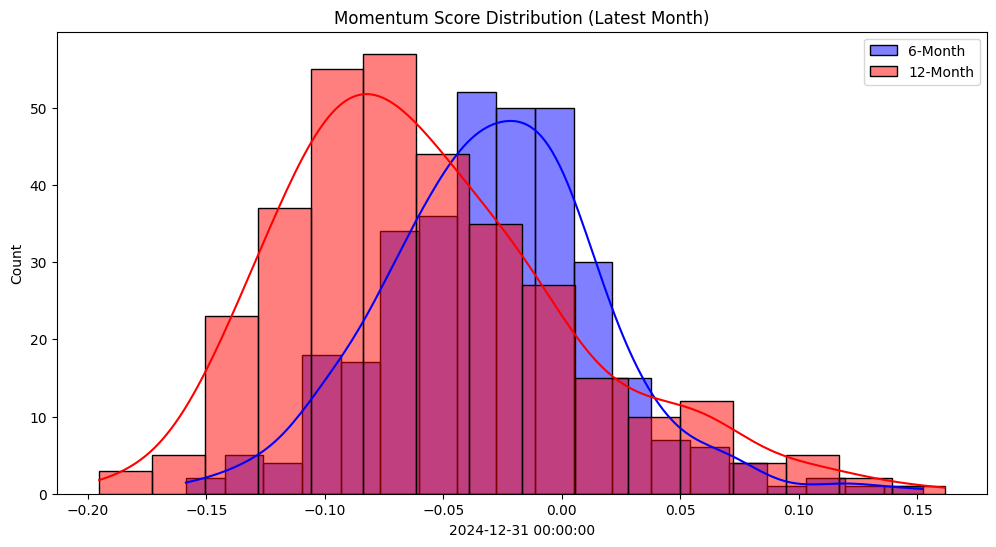

In [306]:
# Plot Momentum Scores
plt.figure(figsize=(12, 6))
sns.histplot(momentum_6m.iloc[-1].dropna(), kde=True, color='blue', label='6-Month')
sns.histplot(momentum_12m.iloc[-1].dropna(), kde=True, color='red', label='12-Month')
plt.legend()
plt.title("Momentum Score Distribution (Latest Month)")
plt.show()

In [307]:
# Step 3: Sorting & Portfolio Construction
# ----------------------------------------
def construct_momentum_portfolios(momentum_data):
    ranked = momentum_data.rank(axis=1, pct=True)
    winners = (ranked >= 0.9)
    losers = (ranked <= 0.1)
    return winners, losers

winners_6m, losers_6m = construct_momentum_portfolios(momentum_6m)
winners_12m, losers_12m = construct_momentum_portfolios(momentum_12m)


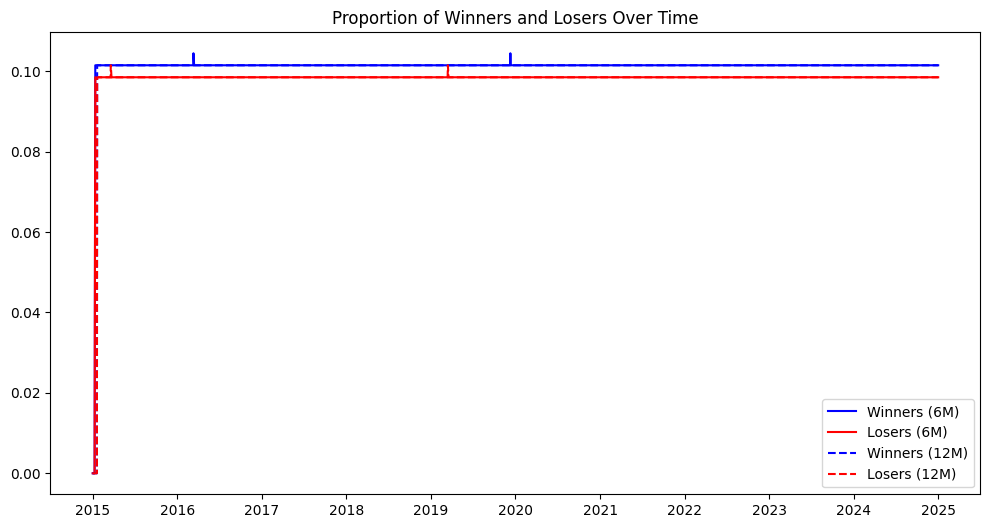

In [308]:
# Plot Proportion of Winners and Losers Over Time
plt.figure(figsize=(12, 6))
plt.plot(winners_6m.mean(axis=1), label='Winners (6M)', color='blue')
plt.plot(losers_6m.mean(axis=1), label='Losers (6M)', color='red')
plt.plot(winners_12m.mean(axis=1), label='Winners (12M)', linestyle='dashed', color='blue')
plt.plot(losers_12m.mean(axis=1), label='Losers (12M)', linestyle='dashed', color='red')
plt.legend()
plt.title("Proportion of Winners and Losers Over Time")
plt.show()

In [309]:
# Step 4: Compute Portfolio Returns
# ---------------------------------
def calculate_portfolio_returns(prices, winners, losers):
    winner_returns = (prices.pct_change() * winners.shift(1)).mean(axis=1)
    loser_returns = (prices.pct_change() * losers.shift(1)).mean(axis=1)
    momentum_returns = winner_returns - loser_returns
    return momentum_returns

momentum_returns_6m = calculate_portfolio_returns(prices, winners_6m, losers_6m)
momentum_returns_12m = calculate_portfolio_returns(prices, winners_12m, losers_12m)


In [310]:
momentum_returns_12m

,0
Date,
2015-01-01,NaN
2015-01-02,0.0
2015-01-05,0.0
2015-01-06,0.0
2015-01-07,0.0
...,...
2024-12-24,-0.000615
2024-12-26,-0.000019
2024-12-27,-0.000677


In [311]:
# prompt: print the number of columns with Nan and 0.0 value in momentum_returns_6m

# Count columns with NaN values
nan_count = momentum_returns_12m.isna().sum().sum()

# Count columns with 0.0 values
zero_count = (momentum_returns_12m == 0.0).sum().sum()

print(f"Number of columns with NaN values: {nan_count}")
print(f"Number of columns with 0.0 values: {zero_count}")


Number of columns with NaN values: 1
Number of columns with 0.0 values: 13


In [312]:
print(momentum_returns_6m.dtypes)
print(momentum_returns_6m.head())


object
Date
2015-01-01    NaN
2015-01-02    0.0
2015-01-05    0.0
2015-01-06    0.0
2015-01-07    0.0
dtype: object


In [313]:
# Convert all values to numeric, forcing non-numeric entries to NaN
momentum_returns_6m = momentum_returns_6m.apply(pd.to_numeric, errors='coerce')
momentum_returns_12m = momentum_returns_12m.apply(pd.to_numeric, errors='coerce')

In [314]:
# Step 5: Statistical Testing
# ---------------------------
def perform_t_test(momentum_returns):
    return ttest_1samp(momentum_returns.dropna(), 0)

t_test_6m = perform_t_test(momentum_returns_6m)
t_test_12m = perform_t_test(momentum_returns_12m)

In [315]:
t_test_6m

TtestResult(statistic=-5.357730976051875, pvalue=9.205158539808203e-08, df=2475)

In [316]:
t_test_12m

TtestResult(statistic=-2.7033623752164777, pvalue=0.006911114642180324, df=2475)

# Step 5.2: Risk-Adjusted Performance Testing


In [317]:
# Function to convert daily data to monthly
def convert_to_monthly(data, method='last'):
    """Aggregates daily data to monthly frequency using the specified method."""
    return data.resample('ME').agg(method)

In [318]:
nifty50.index = pd.to_datetime(nifty50.index)  # Convert index to datetime
nifty50 = convert_to_monthly(nifty50.pct_change(), method='mean')


In [319]:
pb_ratios.index = pd.to_datetime(pb_ratios.index, dayfirst=True)  # Convert index to datetime
pb_ratios = convert_to_monthly(pb_ratios, method='last')

In [320]:
pb_ratios.shape

(120, 335)

In [321]:
market_cap.index = pd.to_datetime(market_cap.index, dayfirst=True)  # Convert index to datetime
market_cap = convert_to_monthly(market_cap, method='last')

In [322]:
market_cap.shape

(120, 335)

In [323]:
prices.shape

(2477, 335)

In [324]:
prices.index = pd.to_datetime(prices.index, dayfirst=True)  # Convert index to datetime
prices = convert_to_monthly(prices, method='last')

In [325]:
prices.shape

(120, 335)

In [326]:
# --------------------------------------------
# Compute Market Excess Return
market_excess_return = nifty50.squeeze() - risk_free.squeeze()

In [327]:
market_excess_return

,0
Date,
2015-01-31,0.002551
2015-02-28,0.000165
2015-03-31,-0.002144
2015-04-30,-0.002070
2015-05-31,0.001563
...,...
2024-08-31,-0.049100
2024-09-30,-0.043881
2024-10-31,-0.047211


In [328]:
# Compute Size (SMB) and Value (HML) Factors
small_cap = market_cap.rank(axis=1, pct=True) <= 0.5
big_cap = market_cap.rank(axis=1, pct=True) > 0.5
high_bm = pb_ratios.rank(axis=1, pct=True) >= 0.7
low_bm = pb_ratios.rank(axis=1, pct=True) <= 0.3
smb_6m = (prices.pct_change() * small_cap.shift(1)).mean(axis=1) - (prices.pct_change() * big_cap.shift(1)).mean(axis=1)
smb_12m = smb_6m.copy()
hml_6m = (prices.pct_change() * high_bm.shift(1)).mean(axis=1) - (prices.pct_change() * low_bm.shift(1)).mean(axis=1)
hml_12m = hml_6m.copy()

In [329]:
hml_6m

,0
Date,
2015-01-31,NaN
2015-02-28,0.012933
2015-03-31,0.02366
2015-04-30,-0.01637
2015-05-31,0.015137
...,...
2024-08-31,0.006732
2024-09-30,0.004161
2024-10-31,0.000213


In [330]:
momentum_returns_6m.index = pd.to_datetime(momentum_returns_6m.index, dayfirst=True)  # Convert index to datetime
momentum_returns_6m = convert_to_monthly(momentum_returns_6m, method='last')

In [331]:
momentum_returns_12m.index = pd.to_datetime(momentum_returns_12m.index, dayfirst=True)  # Convert index to datetime
momentum_returns_12m = convert_to_monthly(momentum_returns_12m, method='last')

In [332]:
momentum_returns_12m.shape

(120,)

In [333]:
# Compute Momentum (WML) Factor for both 6-month and 12-month periods
wml_6m = momentum_returns_6m.shift(1)
wml_12m = momentum_returns_12m.shift(1)

In [334]:
wml_12m

,0
Date,
2015-01-31,NaN
2015-02-28,-0.001132
2015-03-31,0.000187
2015-04-30,-0.000406
2015-05-31,0.000266
...,...
2024-08-31,0.000382
2024-09-30,0.000692
2024-10-31,0.000101


In [335]:
# Construct Factor DataFrames for both 6-month and 12-month rolling periods
factors_6m = pd.DataFrame({
    'Mkt-Rf': market_excess_return.squeeze(),
    'SMB': smb_6m,
    'HML': hml_6m,
    'WML': wml_6m
}).dropna()

In [336]:
factors_6m

,Mkt-Rf,SMB,HML,WML
Date,,,,
2015-02-28,0.000165,0.004831,0.012933,-0.001526
2015-03-31,-0.002144,-0.000959,0.02366,-0.000768
2015-04-30,-0.002070,0.015503,-0.01637,-0.000571
2015-05-31,0.001563,-0.005866,0.015137,-0.000182
2015-06-30,-0.000409,0.00278,0.003647,-0.000160
...,...,...,...,...
2024-08-31,-0.049100,0.004324,0.006732,0.000830
2024-09-30,-0.043881,-0.001311,0.004161,-0.000637
2024-10-31,-0.047211,0.015725,0.000213,0.000437


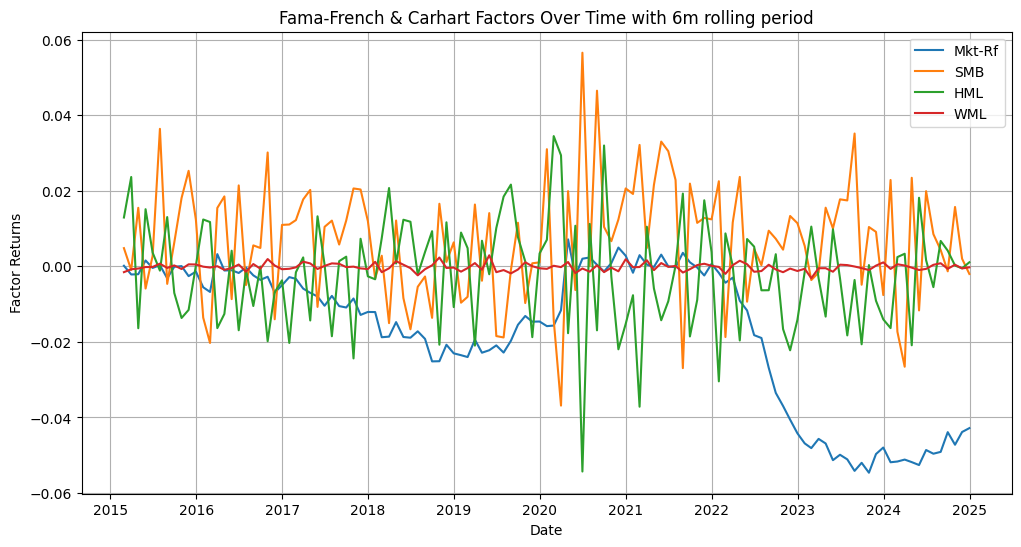

In [337]:
# Plot the factors
plt.figure(figsize=(12, 6))
for column in factors_6m.columns:
    plt.plot(factors_6m.index, factors_6m[column], label=column)
plt.xlabel("Date")
plt.ylabel("Factor Returns")
plt.title("Fama-French & Carhart Factors Over Time with 6m rolling period")
plt.legend()
plt.grid()
plt.show()

In [338]:
factors_12m = pd.DataFrame({
    'Mkt-Rf': market_excess_return.squeeze(),
    'SMB': smb_12m,
    'HML': hml_12m,
    'WML': wml_12m
}).dropna()

In [339]:
factors_12m

,Mkt-Rf,SMB,HML,WML
Date,,,,
2015-02-28,0.000165,0.004831,0.012933,-0.001132
2015-03-31,-0.002144,-0.000959,0.02366,0.000187
2015-04-30,-0.002070,0.015503,-0.01637,-0.000406
2015-05-31,0.001563,-0.005866,0.015137,0.000266
2015-06-30,-0.000409,0.00278,0.003647,0.001439
...,...,...,...,...
2024-08-31,-0.049100,0.004324,0.006732,0.000382
2024-09-30,-0.043881,-0.001311,0.004161,0.000692
2024-10-31,-0.047211,0.015725,0.000213,0.000101


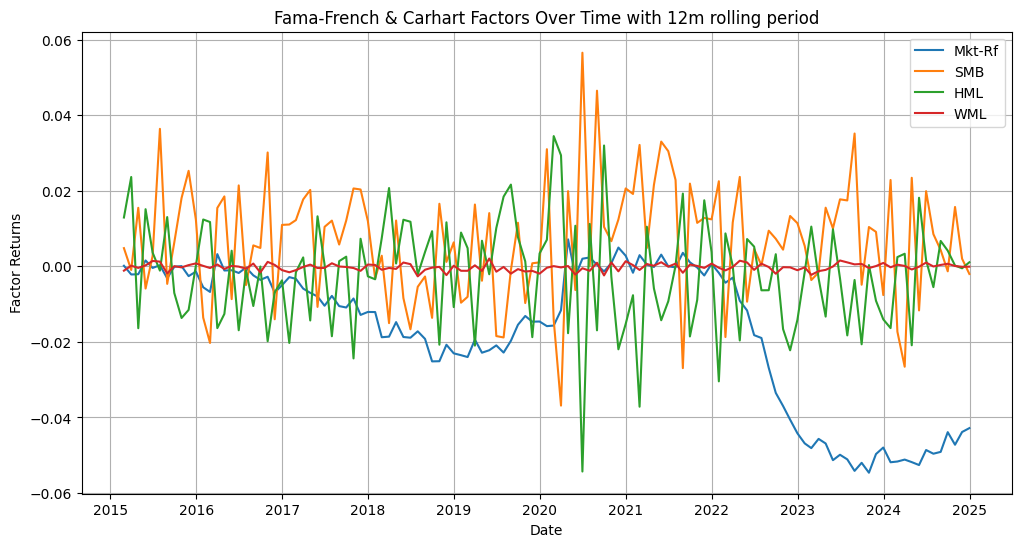

In [340]:
# Plot the factors
plt.figure(figsize=(12, 6))
for column in factors_12m.columns:
    plt.plot(factors_12m.index, factors_12m[column], label=column)
plt.xlabel("Date")
plt.ylabel("Factor Returns")
plt.title("Fama-French & Carhart Factors Over Time with 12m rolling period")
plt.legend()
plt.grid()
plt.show()

In [341]:
momentum_returns_6m.shape

(120,)

In [342]:
# prompt: generate code to drop 1st row of momentum_returns_6m, momentum_returns_6m and risk_free

momentum_returns_6m = momentum_returns_6m.iloc[1:]
momentum_returns_12m = momentum_returns_12m.iloc[1:]
risk_free = risk_free.iloc[1:]


In [343]:
# Convert all factor columns to numeric, forcing errors to NaN
factors_6m = factors_6m.apply(pd.to_numeric, errors='coerce')
factors_12m = factors_12m.apply(pd.to_numeric, errors='coerce')

# Convert momentum returns and risk-free rate to numeric
momentum_returns_6m = pd.to_numeric(momentum_returns_6m, errors='coerce')
momentum_returns_12m = pd.to_numeric(momentum_returns_12m, errors='coerce')
risk_free = pd.to_numeric(risk_free.squeeze(), errors='coerce')

# Drop NaN rows before running regression
factors_6m = factors_6m.dropna()
factors_12m = factors_12m.dropna()


In [344]:
def run_factor_model(momentum_returns, risk_free, factors):
    excess_returns = momentum_returns - risk_free.squeeze()
    X = sm.add_constant(factors)
    model = sm.OLS(excess_returns, X, missing='drop').fit()
    return model  # Return the model instead of model.summary()




<ipython-input-345-6c440d77f45e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Factor", y="Coefficient", data=coef_df, palette="coolwarm", ax=ax)
<ipython-input-345-6c440d77f45e>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(coef_df["Factor"], rotation=45)
<ipython-input-345-6c440d77f45e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Factor", y="Coefficient", data=coef_df, palette="coolwarm", ax=ax)
<ipython-input-345-6c440d77f45e>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_

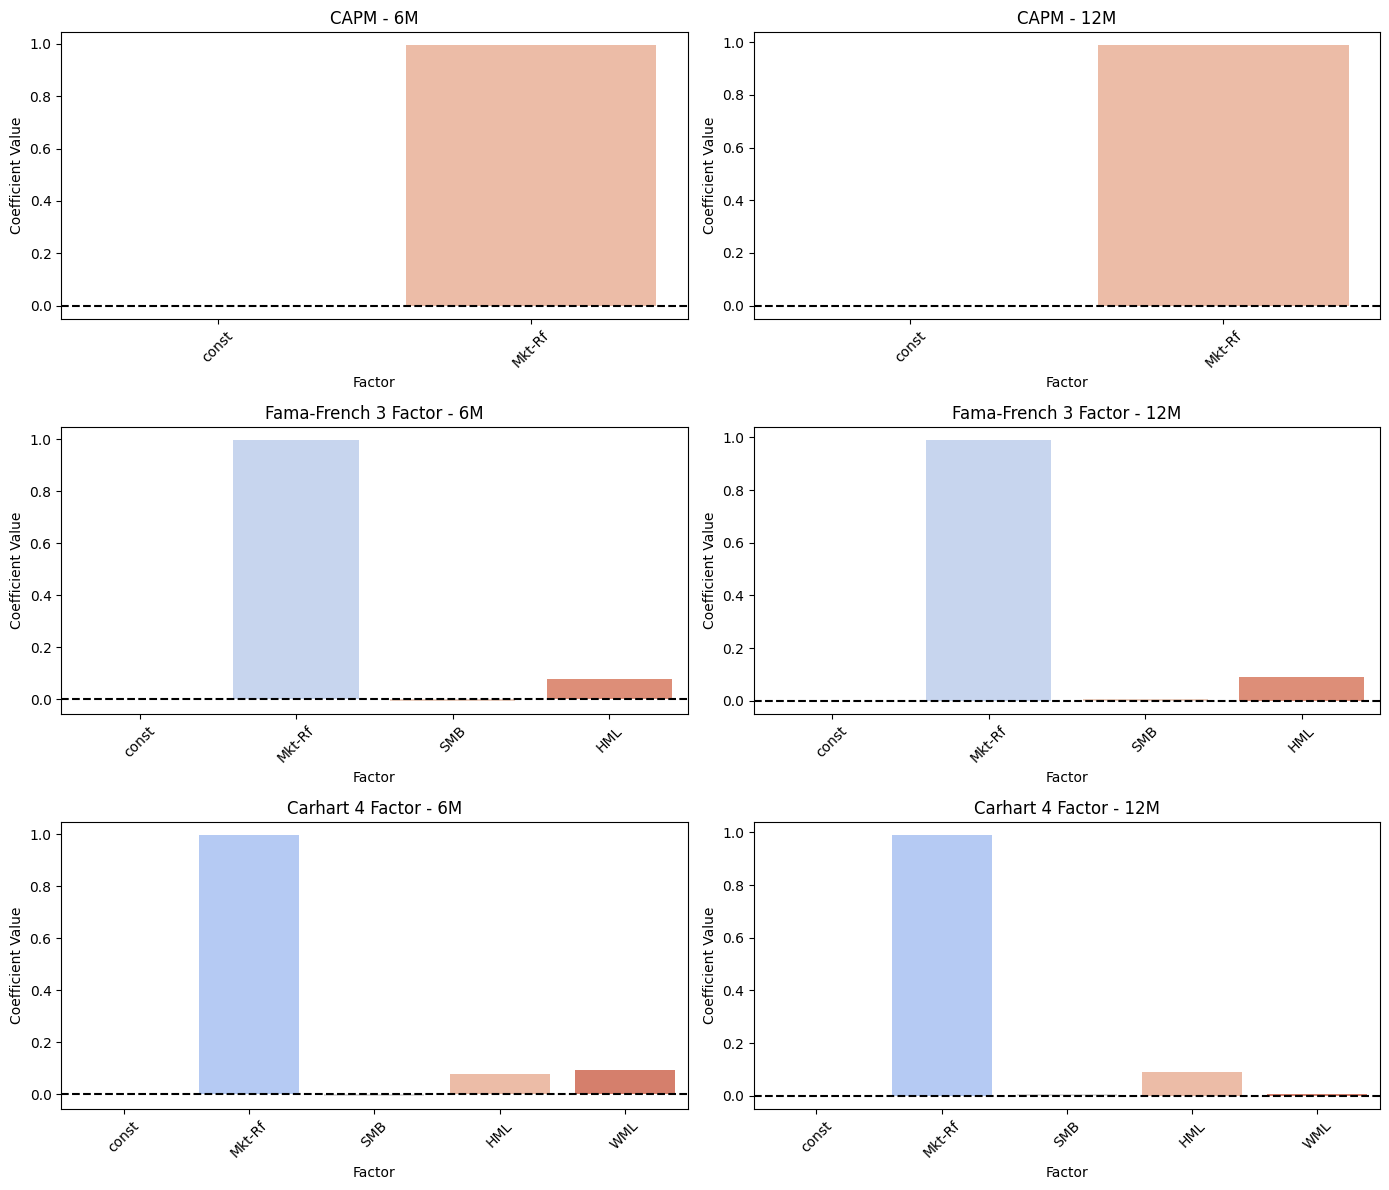

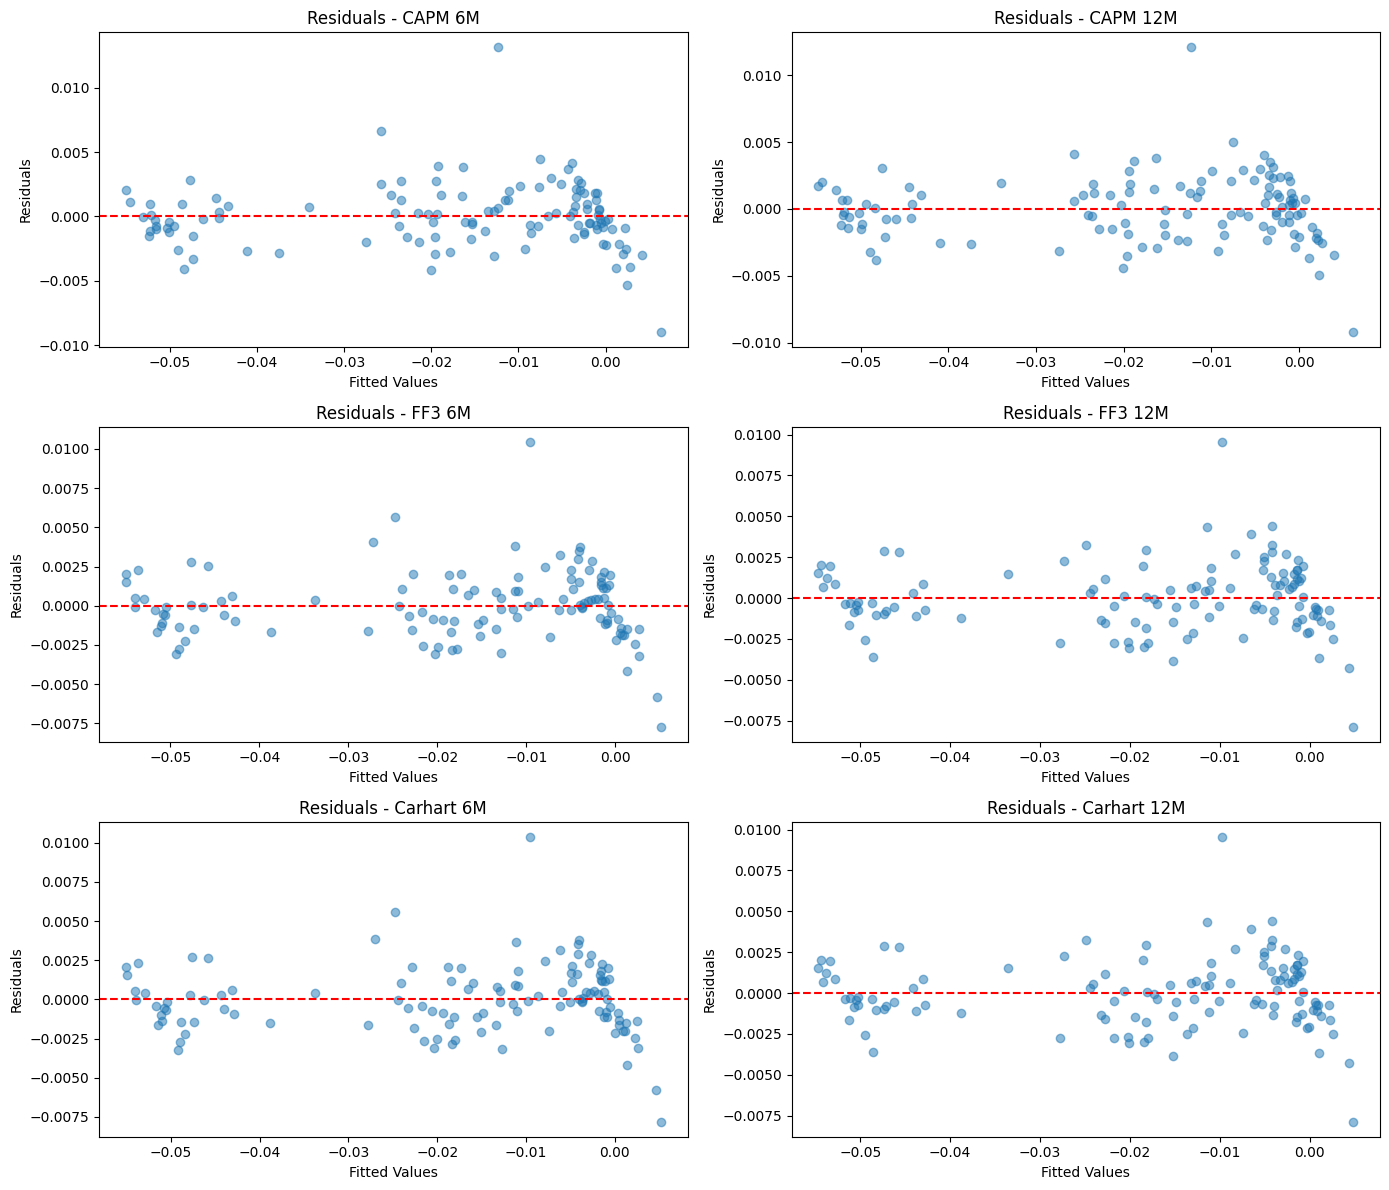

In [345]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot factor loadings
def plot_factor_loadings(ax, model, title):
    coef_series = model.params  # Extract coefficients
    coef_df = pd.DataFrame(coef_series, columns=["Coefficient"]).reset_index()
    coef_df.rename(columns={"index": "Factor"}, inplace=True)

    sns.barplot(x="Factor", y="Coefficient", data=coef_df, palette="coolwarm", ax=ax)
    ax.axhline(0, linestyle="--", color="black")
    ax.set_title(title)
    ax.set_ylabel("Coefficient Value")
    ax.set_xticklabels(coef_df["Factor"], rotation=45)

# Function to plot residuals
def plot_residuals(ax, model, title):
    ax.scatter(model.fittedvalues, model.resid, alpha=0.5)
    ax.axhline(0, linestyle="--", color="red")
    ax.set_xlabel("Fitted Values")
    ax.set_ylabel("Residuals")
    ax.set_title(title)

# Run models again to return correct objects
capm_6m = run_factor_model(momentum_returns_6m, risk_free, factors_6m[['Mkt-Rf']])
capm_12m = run_factor_model(momentum_returns_12m, risk_free, factors_12m[['Mkt-Rf']])
ff3_6m = run_factor_model(momentum_returns_6m, risk_free, factors_6m[['Mkt-Rf', 'SMB', 'HML']])
ff3_12m = run_factor_model(momentum_returns_12m, risk_free, factors_12m[['Mkt-Rf', 'SMB', 'HML']])
carhart_6m = run_factor_model(momentum_returns_6m, risk_free, factors_6m)
carhart_12m = run_factor_model(momentum_returns_12m, risk_free, factors_12m)

# Create figure and axes for factor loading plots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
plot_factor_loadings(axes[0, 0], capm_6m, "CAPM - 6M")
plot_factor_loadings(axes[0, 1], capm_12m, "CAPM - 12M")
plot_factor_loadings(axes[1, 0], ff3_6m, "Fama-French 3 Factor - 6M")
plot_factor_loadings(axes[1, 1], ff3_12m, "Fama-French 3 Factor - 12M")
plot_factor_loadings(axes[2, 0], carhart_6m, "Carhart 4 Factor - 6M")
plot_factor_loadings(axes[2, 1], carhart_12m, "Carhart 4 Factor - 12M")
plt.tight_layout()
plt.show()

# Create figure and axes for residual plots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
plot_residuals(axes[0, 0], capm_6m, "Residuals - CAPM 6M")
plot_residuals(axes[0, 1], capm_12m, "Residuals - CAPM 12M")
plot_residuals(axes[1, 0], ff3_6m, "Residuals - FF3 6M")
plot_residuals(axes[1, 1], ff3_12m, "Residuals - FF3 12M")
plot_residuals(axes[2, 0], carhart_6m, "Residuals - Carhart 6M")
plot_residuals(axes[2, 1], carhart_12m, "Residuals - Carhart 12M")
plt.tight_layout()
plt.show()


In [346]:
capm_6m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     6526.
Date:                Mon, 03 Mar 2025   Prob (F-statistic):          1.79e-104
Time:                        09:00:59   Log-Likelihood:                 544.32
No. Observations:                 119   AIC:                            -1085.
Df Residuals:                     117   BIC:                            -1079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.000     -2.490      0.014      -0.001      -0.000
Mkt-Rf         0.9937      0.012     80.781      0.000       0.969       1.018
==============================================================================
Omnibus:                       39.322   Durbin-Watson:                   2.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.342
Skew:                           0.920   Prob(JB):                     3.87e-48
Kurtosis:                       9.376   Cond. No.                         53.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [347]:
 ff3_6m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2743.
Date:                Mon, 03 Mar 2025   Prob (F-statistic):          8.72e-107
Time:                        09:00:59   Log-Likelihood:                 558.92
No. Observations:                 119   AIC:                            -1110.
Df Residuals:                     115   BIC:                            -1099.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.744      0.084      -0.001    7.41e-05
Mkt-Rf         0.9964      0.011     89.161      0.000       0.974       1.019
SMB           -0.0061      0.018     -0.338      0.736      -0.042       0.029
HML            0.0776      0.019      4.030      0.000       0.039       0.116
==============================================================================
Omnibus:                       24.505   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.658
Skew:                           0.566   Prob(JB):                     2.79e-21
Kurtosis:                       7.220   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [348]:
carhart_6m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2043.
Date:                Mon, 03 Mar 2025   Prob (F-statistic):          4.55e-105
Time:                        09:00:59   Log-Likelihood:                 559.02
No. Observations:                 119   AIC:                            -1108.
Df Residuals:                     114   BIC:                            -1094.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.644      0.103      -0.001       0.000
Mkt-Rf         0.9961      0.011     88.587      0.000       0.974       1.018
SMB           -0.0069      0.018     -0.382      0.703      -0.043       0.029
HML            0.0788      0.020      4.034      0.000       0.040       0.117
WML            0.0944      0.225      0.420      0.676      -0.351       0.540
==============================================================================
Omnibus:                       23.399   Durbin-Watson:                   2.300
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.961
Skew:                           0.526   Prob(JB):                     2.92e-20
Kurtosis:                       7.127   Cond. No.                     1.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [349]:
capm_12m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     6583.
Date:                Mon, 03 Mar 2025   Prob (F-statistic):          1.08e-104
Time:                        09:00:59   Log-Likelihood:                 545.56
No. Observations:                 119   AIC:                            -1087.
Df Residuals:                     117   BIC:                            -1082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.000     -2.868      0.005      -0.002      -0.000
Mkt-Rf         0.9878      0.012     81.137      0.000       0.964       1.012
==============================================================================
Omnibus:                       25.784   Durbin-Watson:                   2.292
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.872
Skew:                           0.545   Prob(JB):                     6.90e-26
Kurtosis:                       7.710   Cond. No.                         53.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [350]:
ff3_12m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2890.
Date:                Mon, 03 Mar 2025   Prob (F-statistic):          4.55e-108
Time:                        09:00:59   Log-Likelihood:                 562.70
No. Observations:                 119   AIC:                            -1117.
Df Residuals:                     115   BIC:                            -1106.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.000     -2.445      0.016      -0.001      -0.000
Mkt-Rf         0.9891      0.011     91.360      0.000       0.968       1.011
SMB            0.0070      0.017      0.403      0.688      -0.027       0.041
HML            0.0919      0.019      4.923      0.000       0.055       0.129
==============================================================================
Omnibus:                       17.572   Durbin-Watson:                   2.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.379
Skew:                           0.364   Prob(JB):                     3.47e-13
Kurtosis:                       6.323   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [351]:
carhart_12m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2149.
Date:                Mon, 03 Mar 2025   Prob (F-statistic):          2.66e-106
Time:                        09:00:59   Log-Likelihood:                 562.70
No. Observations:                 119   AIC:                            -1115.
Df Residuals:                     114   BIC:                            -1102.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.000     -2.348      0.021      -0.001      -0.000
Mkt-Rf         0.9891      0.011     90.811      0.000       0.968       1.011
SMB            0.0069      0.018      0.393      0.695      -0.028       0.042
HML            0.0919      0.019      4.884      0.000       0.055       0.129
WML            0.0066      0.220      0.030      0.976      -0.430       0.443
==============================================================================
Omnibus:                       17.528   Durbin-Watson:                   2.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.146
Skew:                           0.362   Prob(JB):                     3.90e-13
Kurtosis:                       6.317   Cond. No.                     1.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

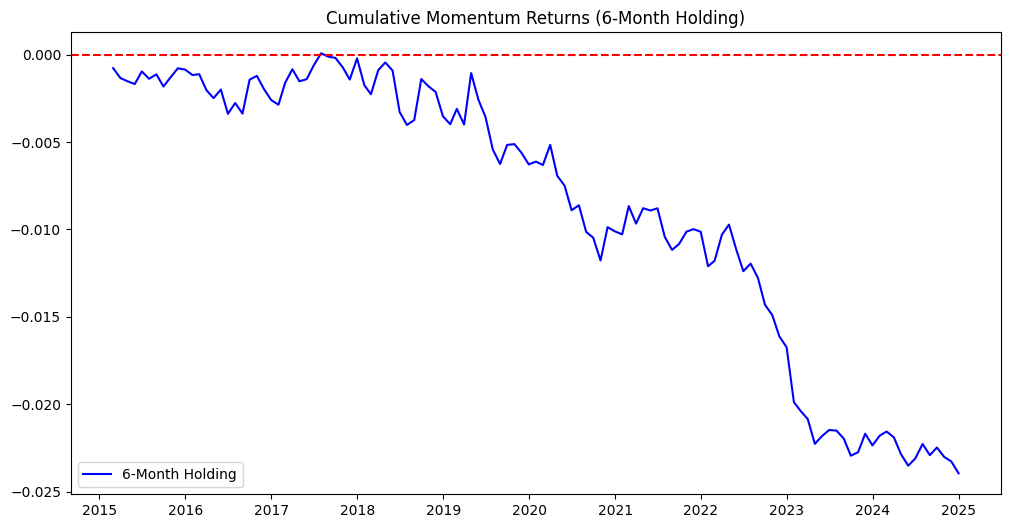

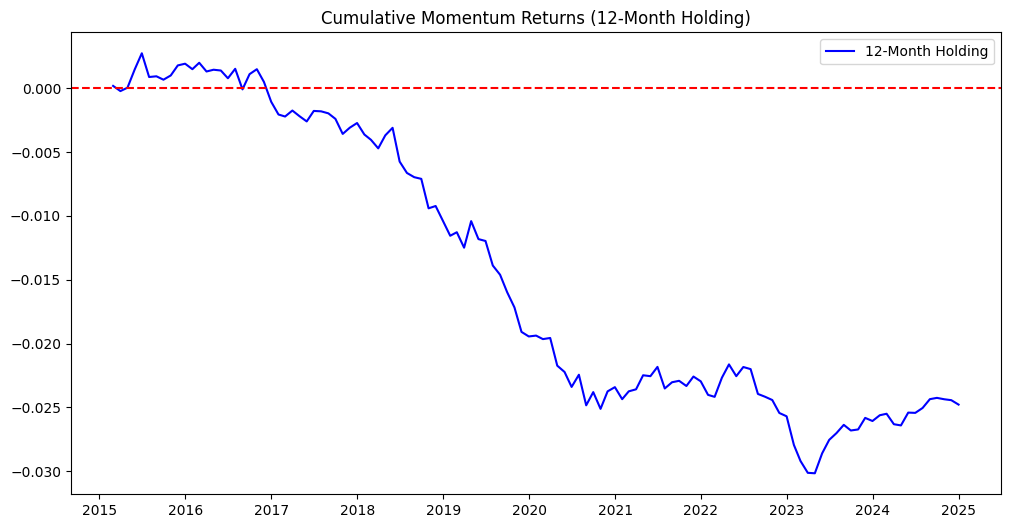

In [352]:
# Step 7: Robustness Checks & Visualization
# ----------------------------------------
def plot_momentum_returns(momentum_returns, title):
    plt.figure(figsize=(12, 6))
    plt.plot(momentum_returns.cumsum(), label=title, color='blue')
    plt.axhline(y=0, linestyle='--', color='red')
    plt.legend()
    plt.title(f"Cumulative Momentum Returns ({title})")
    plt.show()

plot_momentum_returns(momentum_returns_6m, "6-Month Holding")
plot_momentum_returns(momentum_returns_12m, "12-Month Holding")


# Step 7: Robustness Checks
# --------------------------


In [353]:
# 1. Liquidity Adjustment (Removing illiquid stocks)
liquid_stocks = prices.apply(lambda x: x.count() > len(prices) * 0.75, axis=0)
prices_liquid = prices.loc[:, liquid_stocks]

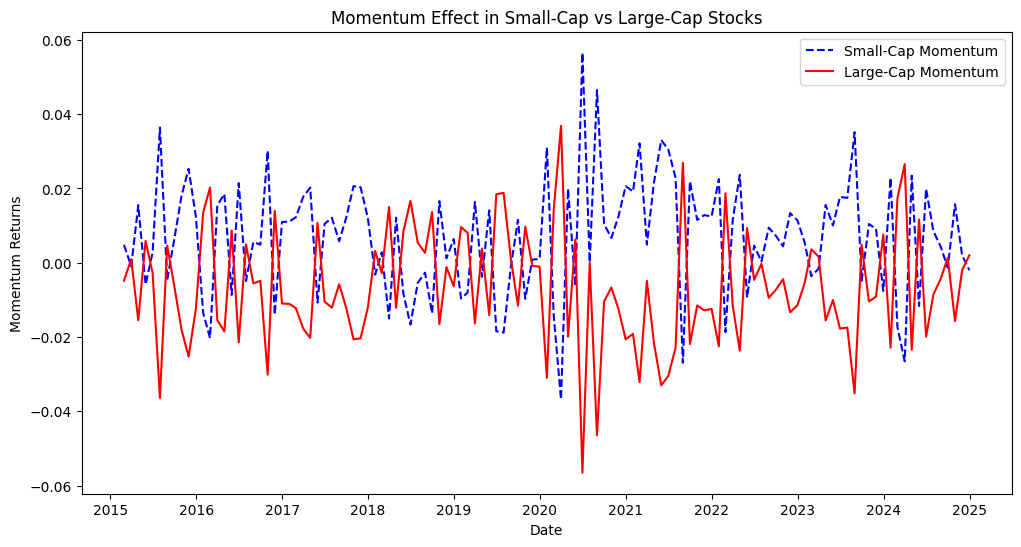

In [362]:
# 2. Size Bias Control (Small-cap vs Large-cap)
small_cap_returns = calculate_portfolio_returns(prices, small_cap, ~small_cap)
big_cap_returns = calculate_portfolio_returns(prices, big_cap, ~big_cap)

plt.figure(figsize=(12, 6))
plt.plot(small_cap_returns, label="Small-Cap Momentum", linestyle='dashed', color='blue')
plt.plot(big_cap_returns, label="Large-Cap Momentum", linestyle='solid', color='red')
plt.legend()
plt.title("Momentum Effect in Small-Cap vs Large-Cap Stocks")
plt.xlabel("Date")
plt.ylabel("Momentum Returns")
plt.show()

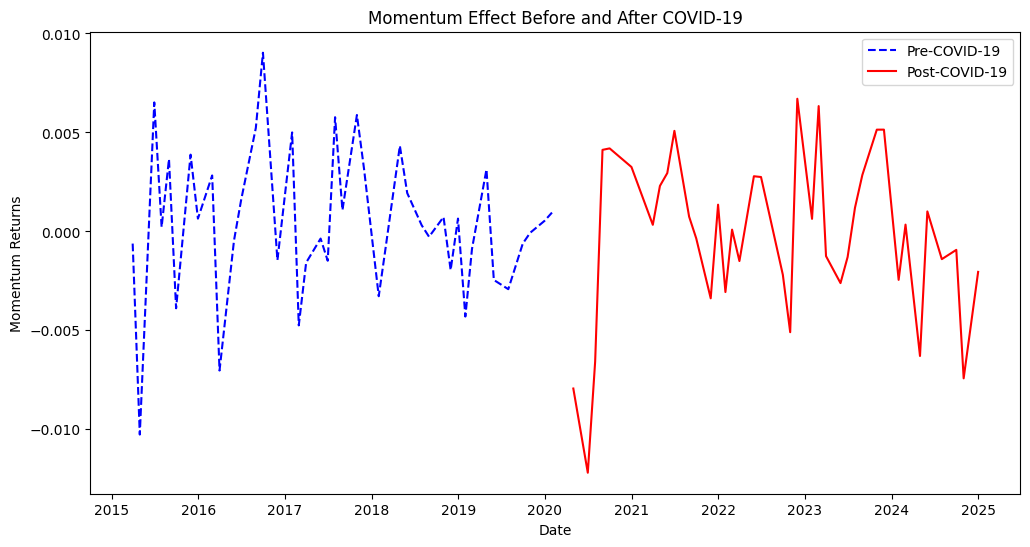

In [355]:
# 3. Sub-Period Analysis (Pre & Post Global Crises)
pre_covid = prices.loc[:'2020-02-29']
post_covid = prices.loc['2020-03-01':]

# Ensure the indices match before using winners and losers
aligned_winners_6m = winners_6m.loc[pre_covid.index.intersection(winners_6m.index)]
aligned_losers_6m = losers_6m.loc[pre_covid.index.intersection(losers_6m.index)]

pre_covid_returns = calculate_portfolio_returns(pre_covid, aligned_winners_6m, aligned_losers_6m)

aligned_winners_6m_post = winners_6m.loc[post_covid.index.intersection(winners_6m.index)]
aligned_losers_6m_post = losers_6m.loc[post_covid.index.intersection(losers_6m.index)]

post_covid_returns = calculate_portfolio_returns(post_covid, aligned_winners_6m_post, aligned_losers_6m_post)

plt.figure(figsize=(12, 6))
plt.plot(pre_covid_returns.dropna(), label="Pre-COVID-19", linestyle='dashed', color='blue')
plt.plot(post_covid_returns.dropna(), label="Post-COVID-19", linestyle='solid', color='red')
plt.legend()
plt.title("Momentum Effect Before and After COVID-19")
plt.xlabel("Date")
plt.ylabel("Momentum Returns")
plt.show()


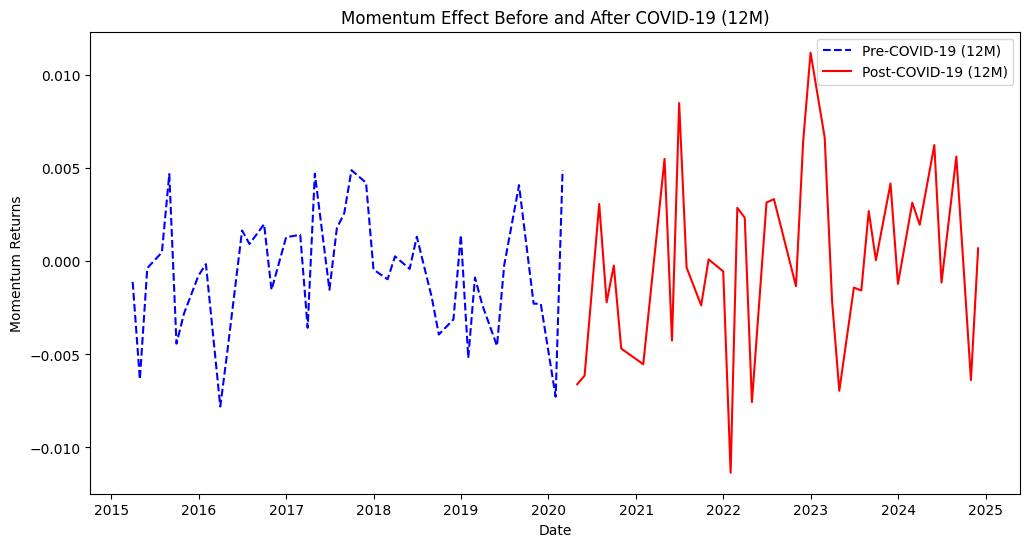

In [361]:
# Ensure index alignment
aligned_winners_12m = winners_12m.reindex(pre_covid.index)
aligned_losers_12m = losers_12m.reindex(pre_covid.index)

pre_covid_returns_12m = calculate_portfolio_returns(pre_covid, aligned_winners_12m, aligned_losers_12m).dropna()

aligned_winners_12m_post = winners_12m.reindex(post_covid.index)
aligned_losers_12m_post = losers_12m.reindex(post_covid.index)

post_covid_returns_12m = calculate_portfolio_returns(post_covid, aligned_winners_12m_post, aligned_losers_12m_post).dropna()

# Plot with corrected data
plt.figure(figsize=(12, 6))
plt.plot(pre_covid_returns_12m, label="Pre-COVID-19 (12M)", linestyle='dashed', color='blue')
plt.plot(post_covid_returns_12m, label="Post-COVID-19 (12M)", linestyle='solid', color='red')
plt.legend()
plt.title("Momentum Effect Before and After COVID-19 (12M)")
plt.xlabel("Date")
plt.ylabel("Momentum Returns")
plt.show()


In [356]:
print(pre_covid_returns.describe())
print(post_covid_returns.describe())


count     42.000000
unique    42.000000
top       -0.000616
freq       1.000000
dtype: float64
count     39.000000
unique    39.000000
top       -0.007938
freq       1.000000
dtype: float64


In [357]:
# 4. Alternative Portfolio Weighting (Value-Weighted)
market_cap_weighted = market_cap.div(market_cap.sum(axis=1), axis=0)
momentum_vw_returns_6m = (prices.pct_change() * winners_6m.shift(1) * market_cap_weighted.shift(1)).sum(axis=1)
momentum_vw_returns_12m = (prices.pct_change() * winners_12m.shift(1) * market_cap_weighted.shift(1)).sum(axis=1)

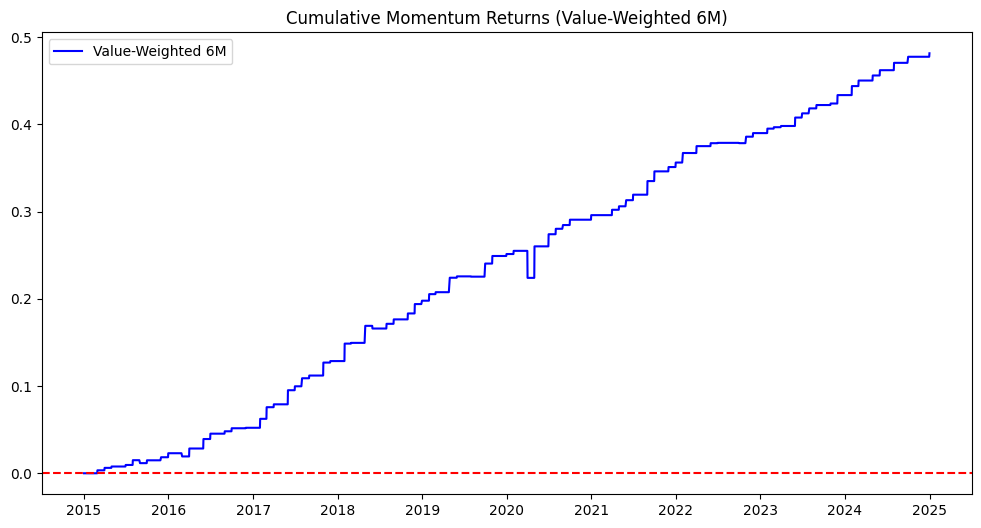

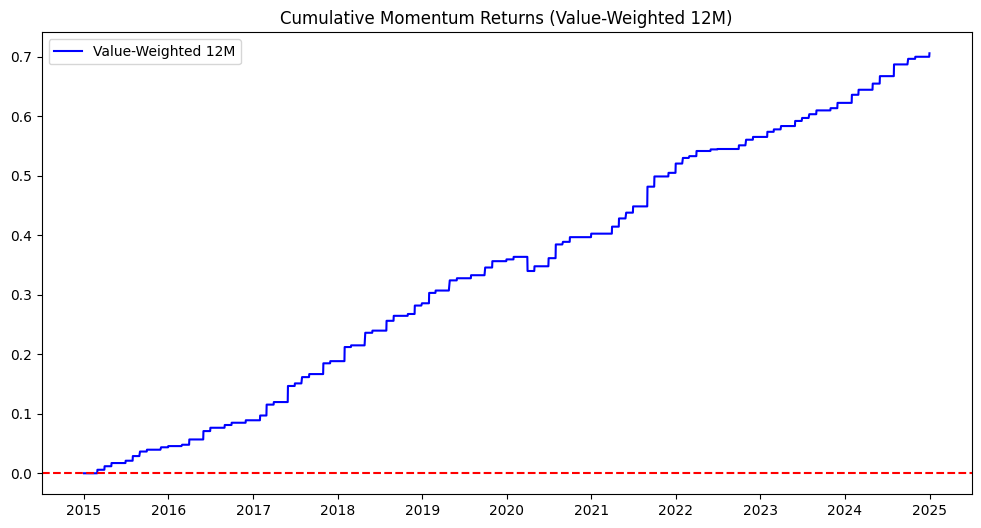

In [358]:
# Visualization of Robustness Tests
plot_momentum_returns(momentum_vw_returns_6m, "Value-Weighted 6M")
plot_momentum_returns(momentum_vw_returns_12m, "Value-Weighted 12M")


#	Expected Findings:

In [363]:
# 1. Check significance of P10-P1 returns
#Momentum Anomaly (P10-P1 Returns Significance)
#Check if t_test_6m and t_test_12m return significant positive values (p-value < 0.05).
print("T-test results for 6-month holding period:", t_test_6m)
print("T-test results for 12-month holding period:", t_test_12m)

T-test results for 6-month holding period: TtestResult(statistic=-5.357730976051875, pvalue=9.205158539808203e-08, df=2475)
T-test results for 12-month holding period: TtestResult(statistic=-2.7033623752164777, pvalue=0.006911114642180324, df=2475)


In [368]:
# Extract Carhart WML Factor Significance
#Extract the coefficient and p-value of WML from carhart_6m and carhart_12m models.
#Ensure WML is positive and statistically significant.
def extract_wml_significance(model):
    wml_coef = model.params.get("WML", np.nan)
    wml_pval = model.pvalues.get("WML", np.nan)
    return wml_coef, wml_pval

wml_6m_coef, wml_6m_pval = extract_wml_significance(carhart_6m)
wml_12m_coef, wml_12m_pval = extract_wml_significance(carhart_12m)

print("Carhart 6M Model: WML Coef =", wml_6m_coef, "p-value =", wml_6m_pval)
print("Carhart 12M Model: WML Coef =", wml_12m_coef, "p-value =", wml_12m_pval)

Carhart 6M Model: WML Coef = 0.09436463170163539 p-value = 0.6755844345287951
Carhart 12M Model: WML Coef = 0.006555590894641861 p-value = 0.9762962646433697


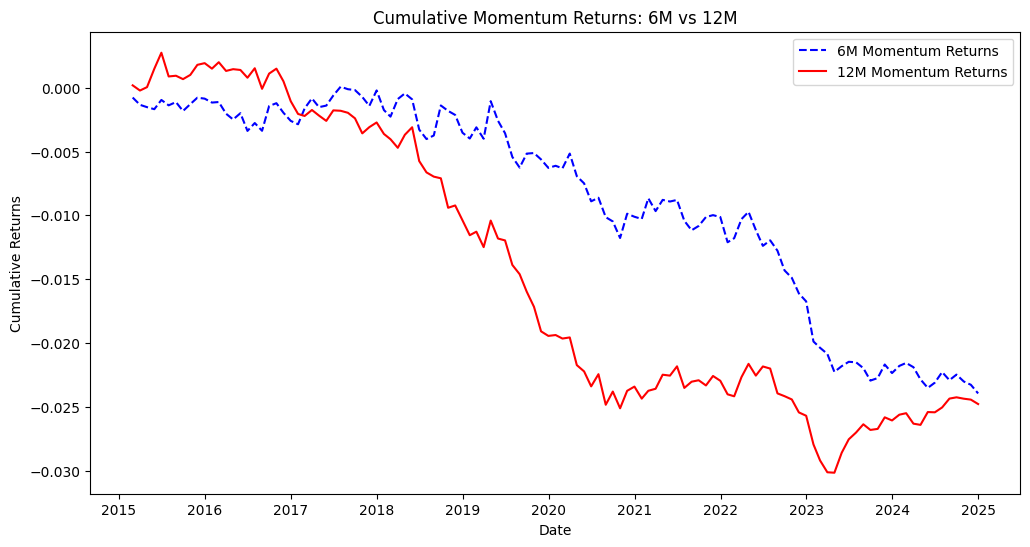

In [366]:
# 3. Compare momentum profitability in 6M vs 12M
plt.figure(figsize=(12, 6))
plt.plot(momentum_returns_6m.cumsum(), label="6M Momentum Returns", linestyle='dashed', color='blue')
plt.plot(momentum_returns_12m.cumsum(), label="12M Momentum Returns", linestyle='solid', color='red')
plt.legend()
plt.title("Cumulative Momentum Returns: 6M vs 12M")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.show()
